In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from DBCV import DBCV
import hdbscan
import csv
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
import json
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import simplekml
import copy
from sklearn.cluster import DBSCAN
import numpy.ma as ma
import rasterio
from pyproj import Proj

In [2]:
class TimeSerie():
    
    def __init__(self):
        pass
    
    def has_null_values(self, serie):
        return self.count_null_values(serie) > 0
    
    def count_null_values(self, serie):
        return serie.isnull().sum().sum()
    
    def compute_null_val_percentage(self, serie):
        return 100 *(1.0 * self.count_null_values(serie) / len(serie))
    
    def interpolate(self, serie):
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def compute_pearson_coef(self, serie):
        return stats.pearsonr(np.squeeze(serie.values), get_days(serie.index))
    
    def compute_linear_reg_pval(self, serie):
        # extraire X et y
        X, y = self.prepare(serie)
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        return  pval[0]
        
    def select(self, serie, filename, ref, min_slope, alpha, sigma, ampl, pc):
        slope   = self.get_slope_value(ref, serie, filename)
        p_value = self.get_linear_reg_pval(serie, alpha)
        vlm = self.vlm
        # filtrage des series avec peu de valeurs
        if self.compute_nul_val_percentage > pc:
            return False
        # filtrage des regressions non significatives
        if p_value > alpha:
            return False
        # filtrage des vitesses faibles
        if abs(vlm) < ampl* sigma:
            return False
         # filtrage des pentes faibles
        if slope < min_slope:
            return False
        # sauvegarder l'état du pixel
        self.set_selected()
        return True
    
    def normalize(self):
        return StandardScaler().fit_transform(self.serie)
    
    # la copie renvoie bien un nouvel objet, il n'y a pas d'effets de bord
    def smooth(self, s, ampl):
        serie = s.copy()
        std = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*std:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def detect_trend(self, alpha):
        X, y = self.prepare()
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
        self.set_linear_reg_pvalue(pval)
        # eliminer le bruit si la regression n'est pas significative (bourrage de zeros)
        if pval > alpha:
            #return self.clone(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))
            return self.deepcopy(pd.DataFrame(0.0, index=self.serie.index, columns=self.serie.columns))  
        else:
            #return self.clone(self.serie.copy())
            return self.deepcopy(self.serie)
    
    def transform(self, alpha):
        return smooth().detect_non_moving_serie(alpha)
        
    def deepcopy(self, serie):
        clone = copy.deepcopy(self)
        clone.set_serie(serie)
        return clone
        
    def compute_adfuller(self, serie):
        adf_result = adfuller(serie)
        adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, value in adf_result[4].items():
            adf_output['Critical Value (%s)'%(key)] = value
        return adf_output[1]
    
    # ce test nécessite d'avoir des données regulièrement échantillonnées
    # Hyopthèse nulle : il existe une racine unitaire (série croissante ou cyclique)
    # Hypthèse alternative : il n'existe pas de racine unitaire (série stationnaire)
    # Si la p-valeur du test est inférireure à O.05, on rejette l'hypothèse nulle et la sériee est stationnaire
    # NB: on recherche des signaux non stationnaires 
    def is_stationary(self, serie, freq='D', alpha=0.05):
        resampled = serie.resample(freq)
        interpolated = upsampled.interpolate(method='linear')
        return self.compute_adfuller(interpolated) < alpha
    
    def get_days(self, serie):
        days = []
        dates = serie.index
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

    def get_Xy(self, serie):
        X = get_days(serie.index)
        y = StandardScaler().fit_transform(serie)
        return np.array(X).reshape(-1,1), y
    
    def prepare(self, serie):
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))]).reshape(-1,1)
        # extraire la cible
        y = StandardScaler().fit_transform(serie)
        return X, y
    
    # that functions gives approximately the same result when use sklearn linear regression
    # x and y and numpy array
    def compute_slope(self, serie):
        x, y = self.prepare(serie)
        return np.cov(x.T, y.T)[0][1] / np.var(x)
    
    def compute_inst_vel(self, serie):
        vels =  []
        for i in range(1, len(serie)-1):
            duration = (serie.index[i+1] - serie.index[i-1]).days
            displacement = serie.iloc[i+1].values[0] - serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        return pd.DataFrame(vels, index=serie.index[1:-1], columns=['vel'])
    
    def impute(self, serie,):
        if self.has_null_values(serie):
            return serie.interpolate(limit_direction='both', inplace=False)
        else:
            return serie
        
    def compute_diff_vect(self, serie):
        disp     = np.diff(np.squeeze(serie.values))
        duration = np.diff(np.squeeze(serie.index)) /  np.timedelta64(1,'D')
        return disp, np.cumsum(duration)
    

In [3]:
class Pixel(TimeSerie):
    
    def __init__(self, id_, lat, lon, topo, ns, ew, ns_vel, ew_vel, mnt_slope, mnt_azimuth):
        super(TimeSerie, self).__init__()
        self.id = id_
        self.lat = lat
        self.lon = lon
        self.topo = topo
        self.ns = self.impute(ns)
        self.ew = self.impute(ew)
        self.azimuths = self.compute_azimuth_serie()
        self.mnt_slope = mnt_slope
        self.mnt_azimuth = mnt_azimuth
        self.ns_vel = ns_vel
        self.ew_vel = ew_vel
        self.is_selected = False
    
    def compute_azimuth_serie(self):
        column = self.ns.columns[0]
        ns = self.ns[column].values
        ew = self.ew[column].values
        azimuths = np.arctan2(ew, ns)
        azimuths = np.where(azimuths >= 0, azimuths, azimuths + 2 * np.pi)
        azimuths = np.degrees(azimuths)
        return pd.DataFrame({'azimuth': pd.Series(azimuths, index=self.ns.index)})
        
    def compute_magnitude_displacement(self):
        x = self.ns.iloc[-1]
        y = self.ew.iloc[-1]
        return math.sqrt(x*x + y*y)

    def compute_vector_coherence(self):
        diff_ns = np.diff(np.squeeze(self.ns.values))
        diff_ew = np.diff(np.squeeze(self.ew.values))
        num = self.compute_norm(np.sum(diff_ns), np.sum(diff_ew))
        den = np.sum(self.compute_norm(diff_ns, diff_ew))
        return num / den 
    
    def compute_norm(self, x, y):
        return np.sqrt(x*x + y*y)
    
    def has_enough_values(self, pc):
        return self.compute_null_val_percentage(self.ns) < pc
    
    def is_linear_regression_significant(self, alpha, ampl):
        ns_sm = self.smooth(self.ns, ampl)
        ew_sm = self.smooth(self.ew, ampl)
        return self.compute_linear_reg_pval(ns_sm) < alpha or self.compute_linear_reg_pval(ew_sm) < alpha
    
    def is_ns_linear_regression_significant(self, alpha):
        return self.compute_linear_reg_pval(self.ns) < alpha
        
    def is_ew_linear_regression_significant(self, alpha):
        return self.compute_linear_reg_pval(self.ew) < alpha
    
    def is_linear_regression_significant_(self, alpha):
        return self.is_ns_linear_regression_significant(alpha) or self.is_ew_linear_regression_significant(alpha)
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def is_moving(self, std, factor):
        return self.get_mean_velocity() > factor*std
    
    def is_to_select1(self, filename, ref, alpha, min_slope, std, factor, pc, ampl_disp):
        return self.is_linear_regression_significant(alpha, ampl_disp) and self.is_moving(std, factor) and self.is_steep(filename, ref, min_slope)
    
    def is_to_select2(self, filename, ref, min_slope, vel_std, amplitude):
        return self.is_moving(vel_std, amplitude) and self.is_steep(filename, ref, min_slope)
    
    def compute_slope(self, ref, file):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, self.lat, self.lon)).read()
        if len(val) == 0:
            raise ValueError('La pente est non valide !')
        return  float(val)
    
    def get_mean_velocity(self):
        return math.sqrt(self.ns_vel*self.ns_vel + self.ew_vel*self.ew_vel)
    
    def compute_interquartile_range(self, serie):
        s = serie.copy().sort_values(by=serie.columns[0], ascending=True)
        q3, q1 = np.percentile(s, [75 ,25])
        iqr = q3 - q1
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    def smooth_by_iqr(self, serie):
        colum = serie.columns[0]
        low, up = self.compute_interquartile_range(serie)
        for n in range(len(serie)):
            if serie.values[n][0] < low or serie.values[n][0] > up:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def is_sign_random(self):
        ns_prop = self.compute_sign_change_proportion_ns()
        ew_prop = self.compute_sign_change_proportion_ew()
        return abs(ns_prop[0] - ns_prop[1]) > 0.5 or abs(ew_prop[0] - ew_prop[1]) > 0.5
    
    
    def is_azimuth_stationary(self, periode='M', alpha=0.05):
        azimuts = self.azimuths
        upsampled = s.resample(periode)
        inter = upsampled.interpolate(method='linear')
        result = adfuller(inter)
        return result[1] < alpha
    
    # calculer la proportion des pixels tels que |mnt_azimuth - azimuth| < tol
    # si on détecte une forte valeur aberrante on supprime le pixel : mnt_azimuth + 180
    def is_azimuth_constant(self, tol, pr):
        attribute = self.azimuths.columns[0]
        mnt_azimuth = self.mnt_azimuth
        azimuths = self.azimuths[attribute].values
        proportion = np.where((azimuths < mnt_azimuth + tol) & (azimuths > mnt_azimuth - tol))[0].shape[0] / azimuths.shape[0]
        return proportion > pr
    
    def is_steep(self, min_slope):
        return  self.mnt_slope > min_slope
        

In [4]:
class Data():
    
    # numéro de la ligne ou commence les données
    num_start = 44
    
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    
    # raise en error when the two file have different sizes
    
    def __init__(self, ew_file_path, ns_file_path, slope_map_path, azimuth_map_path, pc=0.4):
        self.slope_map_raster = rasterio.open(slope_map_path)
        self.azimuth_map_raster = rasterio.open(azimuth_map_path)
        self.slope_map_values = rasterio.open(slope_map_path).read(1)
        self.azimuth_map_values = rasterio.open(azimuth_map_path).read(1)
        self.epsg_code = self.azimuth_map_raster.crs.to_string().lower()
        self.proj = Proj(self.epsg_code, preserve_units=False)
        slopes, azimuths, pixels = self.load(ew_file_path, ns_file_path, pc)
        self.slopes = slopes
        self.azimuths = azimuths
        self.pixels = pixels 
        self.mask = None
        
    def to_date(self, str):
        str_strp = str.strip()
        year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
        return date(year, month, day)

    def load_data_from_csv(self, data_path):
        
        columns = Data.columns
        
        # dictionnaire stockant les données
        data = {column: [] for column in columns}
        # liste des dates 
        indexes = []
        # series temporelles
        series = []
        # liste de dataframes
        df_series = []

        with open(data_path) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=",")
            line_count = 1 
            for row in csv_reader:
                if line_count == Data.num_list_dates:
                    indexes = [row[0].split(' ')[1]] + row[1:]
                if line_count >= Data.num_start:
                    # extraction des premiers attributs
                    for i in range(len(Data.columns)):
                        data[columns[i]].append(row[i])
                    # extraction de l'attribut TS(série temporelle)
                    series.append([float(v) for v in row[len(columns):]])
                line_count  += 1
            if len(indexes) != len(series[0]):
                print('Erreur : Les indexes et les valeurs ne correspondent pas')
            # convertir les index en date
            indexes = [d.strip()[0:8] for d in indexes]
            # créer une liste de dataframes, chacun contenant une série temporelle
            for serie in series:
                tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
                tmp_serie.sort_index(inplace=True)
                df_series.append(tmp_serie)
            # creer un dataframe pour les autres attributs
            df = pd.DataFrame(data)
            for column in df.columns:
                df[column] = pd.to_numeric(df[column], errors='coerce')
            df.set_index('id')

        return df, df_series
    
    def compute_mask(self, ns, pc):
        self.mask = [ns[i].insull().sum().sum() / len(ns[0]) < pc]
        
    def set_pixels(self, pixels):
        self.pixels = pixels
        
    def set_slopes(self, slopes):
        self.slopes = slopes
    
    def set_azimuths(self, azimuths):
        self.azimuths = azimuths
        
        

    def load(self, ew_file_path, ns_file_path, pc=0.4):
        
        slopes, azimuths = None, None
        
        df_ew, ew = self.load_data_from_csv(ew_file_path)
        df_ns, ns = self.load_data_from_csv(ns_file_path)

        df_ew.rename(columns={'Vel': 'Vel_ew'}, inplace=True)
        df_ns.rename(columns={'Vel': 'Vel_ns'}, inplace=True)
        geo = pd.concat([df_ew[['id', 'Lat','Lon','Topo','Vel_ew']], df_ns[['Vel_ns']]], axis=1)
        
        pixels = []
        n = len(ns[0])

        for i in range(len(ns)):
            if ns[i].isnull().sum().sum() / n < pc:
                row, col = self.get_position_in_raster(geo.iloc[i].Lat, geo.iloc[i].Lon)
                mnt_slope = self.get_value_from_slope_map2(row, col)
                mnt_azimuth = self.get_value_from_azimuth_map2(row, col)
                pixels.append(Pixel(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ns[i], ew[i], geo.iloc[i].Vel_ns, geo.iloc[i].Vel_ew, mnt_slope, mnt_azimuth))
        
        return slopes, azimuths, pixels
    
    def convert_lat_lon_to_utm(self, lat, lon):
        return self.proj(lat, lon)
    
    def get_position_in_raster(self, lat, lon):
        x, y = self.convert_lat_lon_to_utm(lat, lon)
        row, col = self.azimuth_map_raster.index(x, y)
        return row, col
    
    def get_value_from_slope_map2(self, row, col):
        return self.slope_map_values[row, col]
    
    def get_value_from_azimuth_map2(self, row, col):
        return self.azimuth_map_values[row, col]
        
    def get_value_from_slope_map(self, lat, lon):
        x, y = self.convert_lat_lon_to_utm(lat, lon)
        row, col = self.slope_map_raster.index(x, y)
        return self.slope_map_values[row, col]
    
    def get_value_from_azimuth_map(self, lat, lon):
        x, y = self.convert_lat_lon_to_utm(lat, lon)
        row, col = self.azimuth_map_raster.index(x, y)
        return self.azimuth_map_values[row, col]
    
    def extract_value_from_raster(self, lat, lon, file, ref='wgs84'):
            val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
            if len(val.strip()) == 0:
                return -9999
            else:
                return float(val)

In [133]:
class DataFromImageCorrelation():
    
    def __init__(self, pixels):
        self.pixels  = pixels
        self.n_cores = multiprocessing.cpu_count()
        self.sigma = self.compute_vlm_std()
        self.non_filtered_ids = []
        self.velocities = []
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def filter_by(self, factor=1.5, azimuth_tol=30, azimuth_pr=0.6, min_slope=15, alpha=0.05):
        self.non_filtered_ids.clear()
        vfunc = np.vectorize(self.is_to_select)
        x = vfunc(np.arange(len(self.pixels)), factor, azimuth_tol, azimuth_pr, min_slope, alpha)
        self.non_filtered_ids = x.nonzero()[0].tolist()
        
    def filter_by2(self, factor=1.5, azimuth_tol=30, azimuth_pr=0.6, min_slope=15, alpha=0.05):
        self.non_filtered_ids.clear()
        arguments =[(n, factor, azimuth_tol, azimuth_pr, min_slope, alpha) for n in range(len(self.pixels))]

        results = None
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.starmap(self.is_to_select, arguments)
        
        self.non_filtered_ids = results.tolist()
    
            
    def is_to_select(self, n, factor, azimuth_tol, azimuth_pr, min_slope, alpha):
        is_random = (self.pixels[n].ns.kurtosis().values[0] < 0) and (self.pixels[n].ew.kurtosis().values[0] < 0)
        is_moving = self.pixels[n].get_mean_velocity() > factor * self.sigma
        is_steep = self.pixels[n].is_steep(min_slope)
        is_azimuth_constant = self.pixels[n].is_azimuth_constant(azimuth_tol, azimuth_pr)
        is_linear_regression_significant = (self.pixels[n].is_ns_linear_regression_significant(alpha) and
               self.pixels[n].is_ew_linear_regression_significant(alpha))
        
        return (is_moving and 
               is_steep and
               not is_random and
               is_azimuth_constant and
               is_linear_regression_significant)
    
    def debug_filter_by(self, factor=1):
        vfunc = np.vectorize(self.debug_is_to_select)
        return vfunc(np.arange(len(self.pixels)), factor)
                
    def compute_vlm_std(self):
        return np.std(np.array([math.sqrt(pixel.ns_vel*pixel.ns_vel + pixel.ew_vel*pixel.ew_vel) for pixel in self.pixels]))
    
    def compute_inst_vels(self, series):
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(TimeSerie().compute_inst_vel, series)
            return results
        
    def compute_velocities(self):
        self.velocities.clear()
        if len(self.non_filtered_ids) == 0:
            self.non_filtered_ids = np.arange(len(self.pixels))
        ns_vels = self.compute_inst_vels([self.pixels[n].ns for n in self.non_filtered_ids])
        ew_vels = self.compute_inst_vels([self.pixels[n].ew for n in self.non_filtered_ids])
        for i in range(len(ns_vels)):
            vels = []
            column = ns_vels[0].columns[0]
            for ns_vel, ew_vel in zip(ns_vels[i][column], ew_vels[i][column]):
                vels.append(self.compute_vel(ns_vel, ew_vel))
            df = pd.DataFrame(vels, index=ns_vels[0].index, columns=['magnitude'])
            self.velocities.append(df)
                
    def set_slope_map_path(self, slope_map_path):
        self.slope_map_path = slope_map_path
    
    # TODO : rajouter une erreur en cas de fichier non existant
    def load_raster(self, raster_path):
        return gdal.Open(raster_path)
        
    def compute_dem_attribute(self, dem_path, dem_attribute_path, attribute):
        if os.path.isfile(dem_path):
            dem = gdal.Open(dem_path)
            dem_attribute = gdal.DEMProcessing(dem_attribute_path, dem, attribute, computeEdges = True)
            dem = None
            dem_attribute = None
        else:
            raise ValueError('Fichier non existant !')
            

In [134]:
class Clustering():
    
    def __init__(self, data, option=0):
        self.data = data
        self.result = None
        self.n_clusters = None
        self.option = option
        
    def select_scaler(serie):
        if self.option == 0:
            return StandardScaler().fit_transform(serie)
        else:
            return RobustScaler.fit_transform(serie)
        
    def get_scaler(self):
        if self.option == 0:
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        return scaler
    
    def normalize(self, series):
        scaler = self.get_scaler()
        return np.array([scaler.fit_transform(serie).reshape(len(serie)) for serie in series])
    
    def compute_similarity_matrix(self, series):
        velocities =  self.data.velocities
        size = len(series)
        distances_matrix = np.zeros(shape=(size, size))
        scaler = self.get_scaler()
        for n in range(size):
            for m in range(n , size):
                s1 = scaler.fit_transform(velocities[n])
                s2 = scaler.fit_transform(velocities[m])
                dist = dtw.distance(s1, s2)
                distances_matrix[n, m] = dist
                distances_matrix[m, m] = dist
        return distances_matrix
    
    def cluster(self, min_cluster_size, min_samples=None, cluster_selection_epsilon=None, precomputed=False):
        data = self.data.velocities
        if not precomputed:
            self.result = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,  gen_min_span_tree=True).fit(self.normalize(data))
        else:
            self.result = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True, metric='precomputed').fit(self.compute_similarity_matrix(data))

    def get_n_clusters(self):
        return 0 if self.result.labels_.max() < 0 else self.result.labels_.max() + 1
    
    def visualize(self):
        projection = TSNE().fit_transform(self.normalize(self.data.velocities))
        color_palette = sns.color_palette('Paired', self.result.labels_.max() + 1 )
        cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in self.result.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, self.result.probabilities_)]
        plt.scatter(*projection.T, s=20, c=cluster_member_colors , linewidth=0, alpha=0.25)
        plt.savefig('tsne.png')
        plt.show()
    
    def plot_cluster_distribution(self, colormap='Dark2'):
        v_count = dict()
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0, 1, self.result.labels_.max() + 1)]
        for label in self.result.labels_:
            if label != -1:
                if label in v_count.keys():
                    v_count[label] += 1
                else:
                    v_count[label] = 1
        pd.Series({k: v for k, v in sorted(v_count.items(), key=lambda item: item[0])}).plot(kind='bar', color=colors)
        return v_count
    
    def get_data_from_class(self, num_label):
        data = []
        for i in range(len(self.result.labels_)):
            if self.result.labels_[i] == num_label:
                data.append(self.data[i])
        return data
    
    def plot_cluster_result(self, n_cols=3):
        labels = self.result.labels_
        n_clusters = labels.max() + 1
        n_rows = int(n_clusters / n_cols) if n_clusters % n_cols == 0 else int(math.ceil(n_clusters / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))
        for num_cluster in range(n_clusters):
            for serie_index in range(len(self.data.magnitudes)):
                if labels[serie_index] == num_cluster:
                    axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(self.data.magnitudes[serie_index], c='blue', alpha=0.2)
            axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        fig.tight_layout()
        plt.show()
        
    # créer un fichier csv contenant les champs : id, lat, lon, numero de la classe
    def generate_csv_file(self):
        rows = []
        fieldnames = ['id', 'Lat', 'Lon', 'cluster']
        data =  self.data.pixels
        non_filtered_ids = self.data.non_filtered_ids
        for n in range(len(non_filtered_ids)):
            rows.append({'id': int(data[n].id), 'Lat': data[n].lat, 'Lon': data[n].lon, 'cluster': self.result.labels_[n]})
        with open('clustering_result.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
            
    # le nombre de markers est limité, on ne prend que les 8 premières classes
    def get_important_labels(self, labels, n_classes=15):
        classes = []
        unique, counts = np.unique(labels, return_counts=True)
        sort_labels = sorted(dict(zip(unique, counts)).items(), key=lambda x: x[1], reverse=True)
        for label, count in sort_labels:
            if label > -1 and len(classes) < n_classes:
                classes.append(label)
        return classes
    
    def generate_kml_file_all(self):
        labels = self.result.labels_
        latitudes = [self.data.pixels[n].lat for n in self.data.non_filtered_ids]
        longitudes = [self.data.pixels[n].lon for n in self.data.non_filtered_ids]
        if labels.max() > -1:
            icones = self.generate_icones2()
            dense_cluster_labels = self.get_important_labels(labels)
            kml=simplekml.Kml()
            fol = kml.newfolder(name="HDBSCAN Clustering")
            for n, v in enumerate(self.data.non_filtered_ids):
                pnt = None
                if labels[n] > -1:
                    pnt = fol.newpoint(description=str(v), coords=[(latitudes[n], longitudes[n])])
                    if labels[n] in dense_cluster_labels:
                        ind = dense_cluster_labels.index(labels[n])
                        pnt.iconstyle.icon.href = icones[ind]
                    else:
                        pnt.iconstyle.icon.href = icones[-1]
            kml.save('Resultats/clustering_results.kml')
            print('kml file created !')
        else:
            print('Hdbscan only found outliers. kml file cannot be generated !')

        
    def generate_kml_file2(self):
        if self.result.labels_.max() > -1:
            icones = self.generate_icones2()
            labels = self.get_important_labels(self.result.labels_)
            kml=simplekml.Kml()
            fol = kml.newfolder(name="HDBSCAN Clustering")
            for i, n in enumerate(self.data.non_filtered_ids, 0):
                if self.result.labels_[i] in labels:
                    ind = labels.index(self.result.labels_[i])
                    pnt = fol.newpoint(description=str(n), coords=[(self.data.pixels[n].lat, self.data.pixels[n].lon)])
                    pnt.iconstyle.icon.href = icones[ind]
            kml.save('clustering_result0.kml')
        else:
            print('Hdbscan only found outliers. kml file cannot be generated !')
            
    def generate_icones2(self):
        base = 'http://maps.google.com/mapfiles/ms/micons/'
        colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
        return [base + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [base + color + '.png' for color in (colors + ['lightblue'])[:]]

    def generate_kml_file(self, scale=2):
        labels = self.result.labels_
        if labels.max() > -1:
            icon_links, scales = self.generate_icones(labels)
            kml=simplekml.Kml()
            fol = kml.newfolder(name="HDBSCAN Clustering")
            labels = self.result.labels_
            for i, n in enumerate(self.data.non_filtered_ids, 0):
                if labels[i] > - 1:
                    pnt = fol.newpoint(description=str(n), coords=[(self.data.pixels[n].lat, self.data.pixels[n].lon)])
                    pnt.iconstyle.icon.href =icon_links[labels[i]]
                    pnt.style.labelstyle.scale = scales[labels[i]]
            kml.save('clustering_result.kml')
        else:
            print('Hdbscan only found outliers. kml file cannot be generated !')
            
    def get_pixel_icon(self, m):
        labels = self.result.labels_
        icon_links, _ = self.generate_icones(labels)
        for i, n in enumerate(self.data.non_filtered_ids, 0):
            if n == m:
                return icon_links[labels[i]]
            
    def generate_icones2(self):
        base = 'http://maps.google.com/mapfiles/ms/micons/'
        colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
        return [base + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [base + color + '.png' for color in (colors + ['lightblue'])[:]]
            
    #http://tancro.e-central.tv/grandmaster/markers/google-icons/mapfiles-ms-micons.html
    def generate_icones(self, labels, scale=2):
        BASE = 'http://maps.google.com/mapfiles/ms/micons/'
        scales = None
        colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
        icon_links = [BASE + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [BASE + color + '.png' for color in (colors + ['lightblue'])[:]]
        n_clusters = labels.max() + 1
        if n_clusters > len(icon_links):
            q = int(n_clusters / len(icon_links))
            r = n_clusters - q*len(icon_links)
            icon_links = (icon_links*q)[:] + icon_links[:r]
            scales = [scale*t for t in range(len(icon_links))]
        else:
            scales = [scale]*n_clusters
        return icon_links, scales
    
    # coefficient de silhouette ?
    def validate(self):
        return DBCV(self.data.magnitudes, self.result.labels_, dist_function=euclidean)

In [135]:
class Utility():
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    
    def __init__(self):
        pass
    
    def generate_kml_file(self, latitudes, longitudes, color, kml=None, filename='visualization', generate=True):
        
        kml_obj = None
        fol = None
        if kml is None:
            kml_obj = simplekml.Kml()
        else:
            kml_obj = kml
            
        for n, coords in enumerate(zip(latitudes, longitudes)):
            pnt = kml_obj.newpoint(description=str(n), coords=[(coords[0], coords[1])])
            pnt.iconstyle.icon.href = self.url + color + '-dot.png'
        
        if generate:
            kml.save(filename + '.kml')
            return  None
        else:
            return kml

    def generate_kml_file_classes(self, latitudes1, longitudes1, latitudes2, longitudes2, output_filename='visualization', color1='red', color2='green'):
        
        kml = self.generate_kml_file(latitudes1, longitudes1, color1, generate=False)
        _ = self.generate_kml_file(latitudes2, longitudes2, color2, generate=True)
            
        kml.save(output_filename + '.kml')

In [136]:
class Visualization():

    def __init__(self):
        pass
    
    def plot_displacement(self, ts):
        
        days = get_days(ns_ts.index)
        fig, ax = plt.subplots(figsize=(15,5))
    
        ax[0].plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
        ax[1].plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
        
        plt.legend()
        plt.legend(loc='best')
        plt.show()
    
    def plot_displacement_vel(self, ns_ts, ew_ts):
        
        days = get_days(ns_ts[0].index)

        fig, ax_left = plt.subplots(figsize=(15,5))
        ax_right = ax_left.twinx()

        p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
        p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

        ax_left.set_xlabel("number of days since the first measure")
        ax_left.set_ylabel("displacement")
        ax_right.set_ylabel("velocity")

        lns = [p1, p2]

        ax_left.legend(handles=lns, loc='best')
        fig.tight_layout()
        plt.show()
        
    def plot_disp_ns_ew(self, pixel):

        fig, ax = plt.subplots(3, 1, figsize=(15,10))

        ax[0].plot(pixel.ns, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(pixel.ew, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()
        
        ax[2].plot(pixel.azimuths, color='green', label='azimuth (°)', marker='o', linewidth=2)
        ax[2].set_title('azimuth variations')
        ax[2].set_xlabel('time')
        ax[2].set_ylabel('azimuth')
        ax[2].legend()
        
        plt.savefig('displacement_profile.png')
        fig.tight_layout()
        plt.show()
        
    def plot_disp_vel(self, ns_ts, ew_ts, vels):
        
        fig, ax = plt.subplots(3, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()

        ax[2].plot(vels, color='green', label='vxelocity (m/day)', marker='o', linewidth=2)
        ax[2].set_title('Velocity magnitude')
        ax[2].set_xlabel('time')
        ax[2].set_ylabel('velocity')
        ax[2].legend()

        fig.tight_layout()
        plt.show()
        
    def plot_series(series, num_rows=48677, num_cols=5, colormap='tab20'):
        
        plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

        for num_row in range(num_rows):
            for num_col in range(num_cols):
                if num_row*num_cols + num_col < len(series):
                    axs[num_row, num_col].plot(series[num_row*num_cols + num_col], color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                    #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))
        plt.show()
    
    def generate_km_file_testing(self, pixels, listes, colors):
        url = 'http://maps.google.com/mapfiles/ms/micons/'
        kml = simplekml.Kml()
        for m in range(len(listes)):
            for n in listes[m]:
                lat, lon = pixels[n].lat, pixels[n].lon
                pnt = kml.newpoint(description=str(n), coords=[(lat, lon)])
                pnt.iconstyle.icon.href = url + colors[m] + '-dot.png'
        kml.save('testing_points' + '.kml')

        
    def generate_kml_file(self, mask, latitudes, longitudes, color, filename='visualization'):
        
        url = 'http://maps.google.com/mapfiles/ms/micons/'
        kml = simplekml.Kml()
        for n, coords in enumerate(zip(latitudes, longitudes)):
            if not mask[n]:
                pnt = kml.newpoint(description=str(n), coords=[(coords[0], coords[1])])
                pnt.iconstyle.icon.href = url + color + '-dot.png'
        kml.save(filename + '.kml')
        
    def generate_kml_file3(self, mask, latitudes, longitudes, color, filename='visualization'):
        
        url = 'http://maps.google.com/mapfiles/ms/micons/'
        kml = simplekml.Kml()
        for n in mask:
                latitude = latitudes[n]
                longitude = longitudes[n]
                pnt = kml.newpoint(description=str(n), coords=[(latitude, longitude)])
                pnt.iconstyle.icon.href = url + color + '-dot.png'
        kml.save(filename + '.kml')

# Chargement des données

In [12]:
non_signals = [47521, 40813, 47557, 47841, 49882, 43172, 48141, 41143, 45777, 44317,5842, 42256, 44879, 39398 ,46649]
signals = [34900,28490, 37520, 36659, 42193, 30546, 34313, 38980, 30237, 33451, 22367, 24713, 22961, 25887, 28509]

In [13]:
ew_path = 'rasters/Lavalette/MM_TIO_EW_31TGK_20151227_to_20200906.csv'
ns_path = 'rasters/Lavalette/MM_TIO_NS_31TGK_20151227_to_20200906.csv'
slope_map_path = 'rasters/Lavalette/slope_lavalette.tif'
azimuth_map_path = 'rasters/Lavalette/azimuth_lavalette.tif'
data = Data(ew_path, ns_path, slope_map_path, azimuth_map_path)

In [38]:
d1 = data.pixels[34900].azimuths.iloc[1:]
d2 = np.full(len(d1),data.pixels[34900].mnt_azimuth)
# Example of the Student's t-test
from scipy.stats import ttest_ind
stat, p = ttest_ind(d1['azimuth'].values, d2, equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=30.000, p=0.000
Probably different distributions


In [39]:
d1['azimuth']

2016-04-25    212.479894
2016-06-24    206.553926
2016-08-03    227.914482
2016-08-13    244.749708
2016-08-23    252.473277
                 ...    
2020-07-23    310.613471
2020-08-07    309.668452
2020-08-27    312.452273
2020-09-01    312.590480
2020-09-06    313.973697
Name: azimuth, Length: 86, dtype: float64

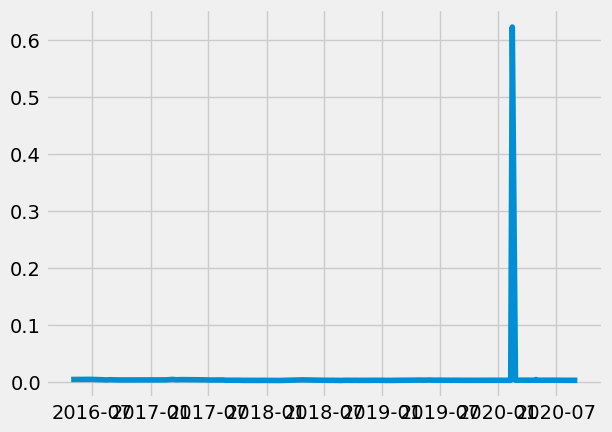

In [78]:
plt.plot(1 / data.pixels[33451].azimuths)
plt.show()

In [138]:
Image_Correlation_processing = DataFromImageCorrelation(data.pixels)

In [139]:
Image_Correlation_processing.filter_by(factor=2, azimuth_tol=100, azimuth_pr=0.2, min_slope=15, alpha=0.05)

In [140]:
len(Image_Correlation_processing.non_filtered_ids)

1183

In [141]:
Image_Correlation_processing.compute_velocities()

In [146]:
'''
factor = 2 
azimuth_tol = 100
azimuth = 0.2
min_slope = 15
alpha = 0.05
min_cluster_size = 50
min_samples = 1
'''
clustering = Clustering(Image_Correlation_processing, option=0)
clustering.cluster(min_cluster_size=50, min_samples=10, cluster_selection_epsilon=None, precomputed=False)
clustering.generate_kml_file_all() 

/home/eost-user/miniconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


kml file created !


In [129]:
data.pixels[11153].ew.kurtosis()

displacement    4.333411
dtype: float64

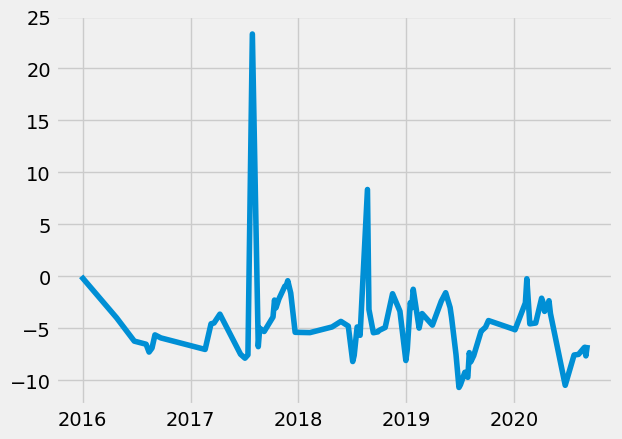

In [132]:
plt.plot(data.pixels[26788].ns)
plt.show()

In [119]:
n = 30546
tol = 50
plt.plot(data.pixels[n].azimuths.iloc[1:])
azimuths = data.pixels[n].azimuths.iloc[1:].values.flatten()
data.pixels[n].azimuths.mean().values[0]
mnt_azimuth = data.get_value_from_azimuth_map(data.pixels[n].lat, data.pixels[n].lon)
std = data.pixels[n].azimuths.std().values[0]
mean = data.pixels[n].azimuths.mean().values[0]
#print(mnt_azimuth)
#print(std)
print(100 * np.where((azimuths < mnt_azimuth + tol) & (azimuths > mnt_azimuth - tol))[0].shape[0] / azimuths.shape[0])
#print(100 * np.where((azimuths < mean +  std) & (azimuths > mean - std/2))[0].shape[0] / azimuths.shape[0])
#print(data.pixels[n].azimuths.kurtosis())
plt.axhline(y=mnt_azimuth, color='red')

# kurtosis 
# une valeur négative signifie que la distribution est plate
# une valeur nulle que la distribution est gaussienne
# une valeur positive implique que la distribution à un pic très resseré

1.1627906976744187


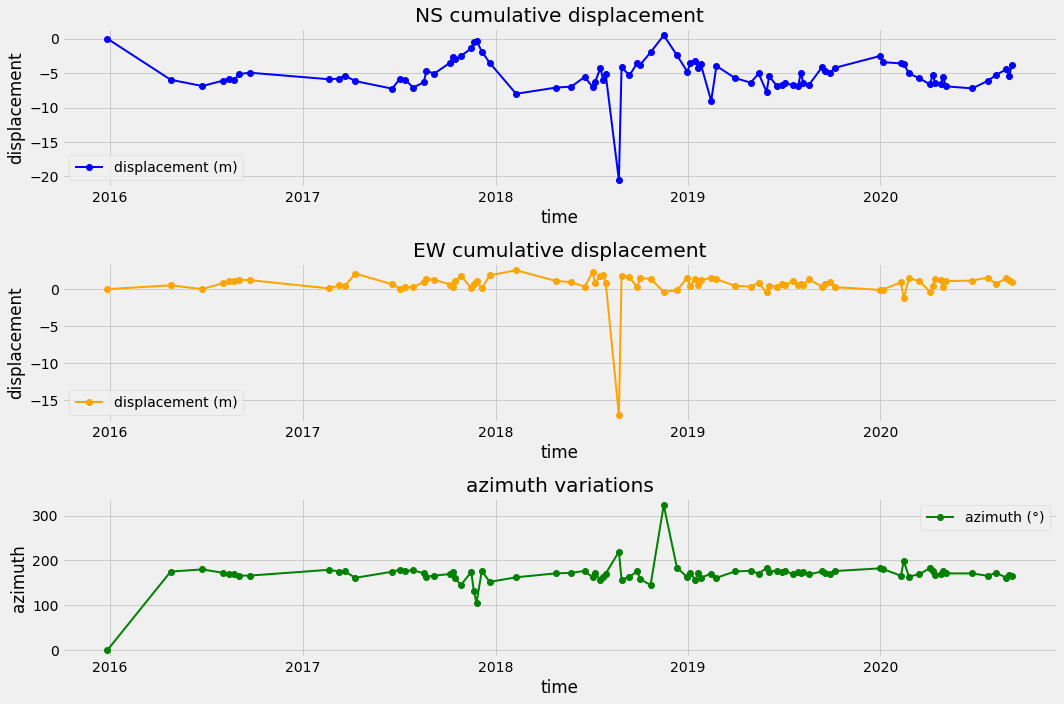

In [122]:
#viz.plot_disp_ns_ew(Data.pixels[n].ns , Data.pixels[n].ew)
Visualization().plot_disp_ns_ew(Data.pixels[75000])

In [21]:
#Data = DataFromImageCorrelation(RASTER_FOLDER_PATH, DEM_FILENAME, geo.head(n), df_ns_ts[:n], df_ew_ts[:n])
Data = DataFromImageCorrelation(pixels, raster_folder_path, dem_filename)

# Analyse des filtres

## Filtre vitesse & regression linéaire

In [ ]:
factors = [1.5, 2, 2.5, 3]
for factor in factors:
    print('start')
    Data.test_filter(factor)
    print('end')
    Visualization().generate_kml_file3(Data.non_filtered_ids, latitudes, longitudes, 'yellow', filename='filtre_vel_reg_factor=' + str(factor))
    print('k')

## Filtre Vitesse

In [18]:
def plot_raster(raster, cmap='gray'):
    values = raster.GetRasterBand(1).ReadAsArray()
    plt.figure()
    plt.imshow(values, cmap = cmap)
    plt.colorbar()
    plt.show()
    
def compute_slope_azimuth_map(dem_path, output_name):
    dem = gdal.Open(dem_path)
    slope_map = gdal.DEMProcessing('rasters/' + output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)

In [19]:
dem_path = 'rasters/31TGK_copernicus_dem.tif'
compute_slope_azimuth_map(dem_path, 'slope_azimuth_map')

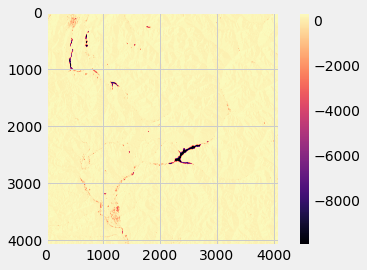

In [477]:
plt.rcParams["axes.grid"] = True
path = 'rasters/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif'
slope_azimuth_path = 'rasters/slope_azimuth_map.tif'
slope_azimuth_raster = gdal.Open(slope_azimuth_path)
#magnitudes_map = gdal.Open(path)
#slope_map = gdal.DEMProcessing('rasters/slope_map.tif', dem, 'slope', computeEdges = True)
plot_raster(slope_azimuth_raster, cmap='magma')

In [64]:
def extract_value_from_raster(lat, lon, file='rasters/slope_azimuth_map.tif', ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return  float(val)

ref = 'wgs84'
file = 'rasters/slope_azimuth_map.tif'

In [ ]:
file = 'rasters/Lavalette/azimuth_lavalette.tif'
azimuths = []
arguments = 
for lat, lon in zip(latitudes, longitudes):
    val = extract_value_from_raster(file, ref, lat, lon)
    azimuths.append(val)

## Filtre azimuth

In [81]:
'''
atan2 renvoie une valeur dans [-pi, pi]
l'azimut calculé par gdal est  compris en entre 0 et 360 degrés.
il faut donc rajouter 2pi à atan2 lorsque sa valeur est négative sachant que atan2
renvoie une valeur comprise entre -pi et pi
'''

"\natan2 renvoie une valeur dans [-pi, pi]\nl'azimut calculé par gdal est  compris en entre 0 et 360 degrés.\nil faut donc rajouter 2pi à atan2 lorsque sa valeur est négative sachant que atan2\nrenvoie une valeur comprise entre -pi et pi\n"

In [82]:
 def plot_(liste, azimuths, pixels_azimuths,  name):
         
        fig, ax = plt.subplots(2, 1, figsize=(15,10))
        
        for n in range(len(liste)):
            ax[n].plot(azimuths[n], color='blue', label='displacement (m)', marker='o', linewidth=2)
            ax[n].set_title('NS cumulative displacement')
            ax[n].set_xlabel('time')
            ax[n].set_ylabel('azimuth (°)')
            ax[n].axhline(y=pixels_azimuths[n], color='r', label='pixel azimuth', linestyle='-', linewidth=1)
        
        plt.savefig(name + '.png')
        fig.tight_layout()
        plt.show()

In [90]:
import subprocess

cmd1 = [
        "gdaltindex",
        "rasters/shapefiles/dem_lavalette.shp",
        "rasters/Lavalette/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif"
        ]
subprocess.run(cmd1)

CompletedProcess(args=['gdaltindex', 'rasters/shapefiles/dem_lavalette.shp', 'rasters/Lavalette/MM_TIO_Magnitude_31TGK_20151227_to_20200906.tif'], returncode=0)

In [82]:
# create DEM for Lavalette area
def cut_raster(ds, raster_output, shapefile_output, xres, yres):
    small_dem = gdal.Warp(raster_output, ds, cutlineDSName=shapefile_output, cropToCutline=True, dstNodata=np.nan, xRes=xres, yRes=yres, resampleAlg='cubic')
    small_dem = None

def compute_slope_azimuth_map(dem_path, output_name):
    dem = gdal.Open(dem_path)
    slope_map = gdal.DEMProcessing(output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)
    slope_map = None
    dem = None

In [96]:
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
x, y = gdal_azimuths_lavalette_raster.transform * (1, 1)
lat, lon = proj(x, y, inverse=True)
print(lat, lon)

A = extract_value_from_raster(lat, lon, 'rasters/azimuths/slope_azimuths_lavalette.tif')
print(A)

6.628042184810065 44.4219127157047
206.565048217773


In [93]:
def extract_value_from_raster(lat, lon, file, ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return  float(val)

In [158]:
pixel_azimuths = None
with Pool(4) as p:
    pixel_azimuths = p.starmap(extract_value_from_raster, [(pixel.lat, pixel.lon) for pixel in pixels[20000:30000]])

In [36]:
liste = [21791, 35193, 36936, 38989, 44605, 43999, 44011, 43442, 48357, 50395, 46907, 48651]
signals = [34900, 28490, 37520, 36659, 42193, 30546, 34313, 38980, 30237, 33451, 22367, 24713, 22961, 25887, 28509]
non_signals = [47521, 40813, 47557, 47841, 49882, 43172, 48141, 41143, 45777, 44317,5842, 42256, 44879, 39398 ,46649]

pixels_azimuths, azimuths = [], []
for n in non_signals:
    pixel_azimuth = extract_value_from_raster(pixels[n].lat, pixels[n].lon, file)
    pixels_azimuths.append(pixel_azimuth)
    azimuths.append(compute_azimuth_serie4(pixels[n]))
    
#Visualization().generate_km_file_testing(pixels, [signals, non_signals], ['green', 'yellow'])

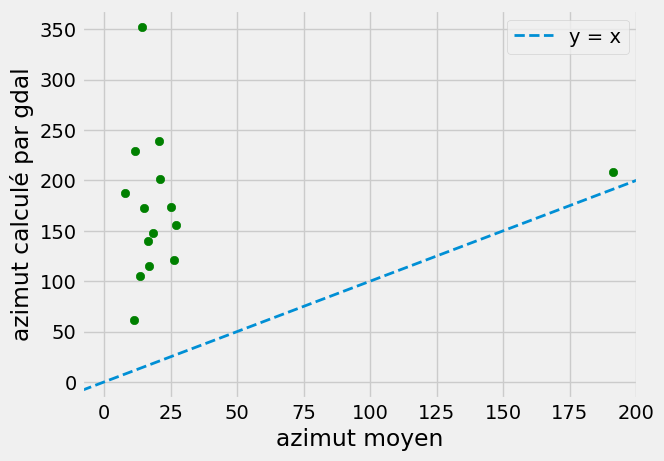

In [52]:
plt.scatter(azimuths, pixels_azimuths,  color='g')
plt.axline((1, 1), slope=1, label='y = x', linestyle='--', linewidth=2)
plt.xlabel('azimut moyen')
plt.ylabel('azimut calculé par gdal')
plt.legend(loc='best')
#plt.savefig('non_landslide_azimuth.jpg')
plt.show()

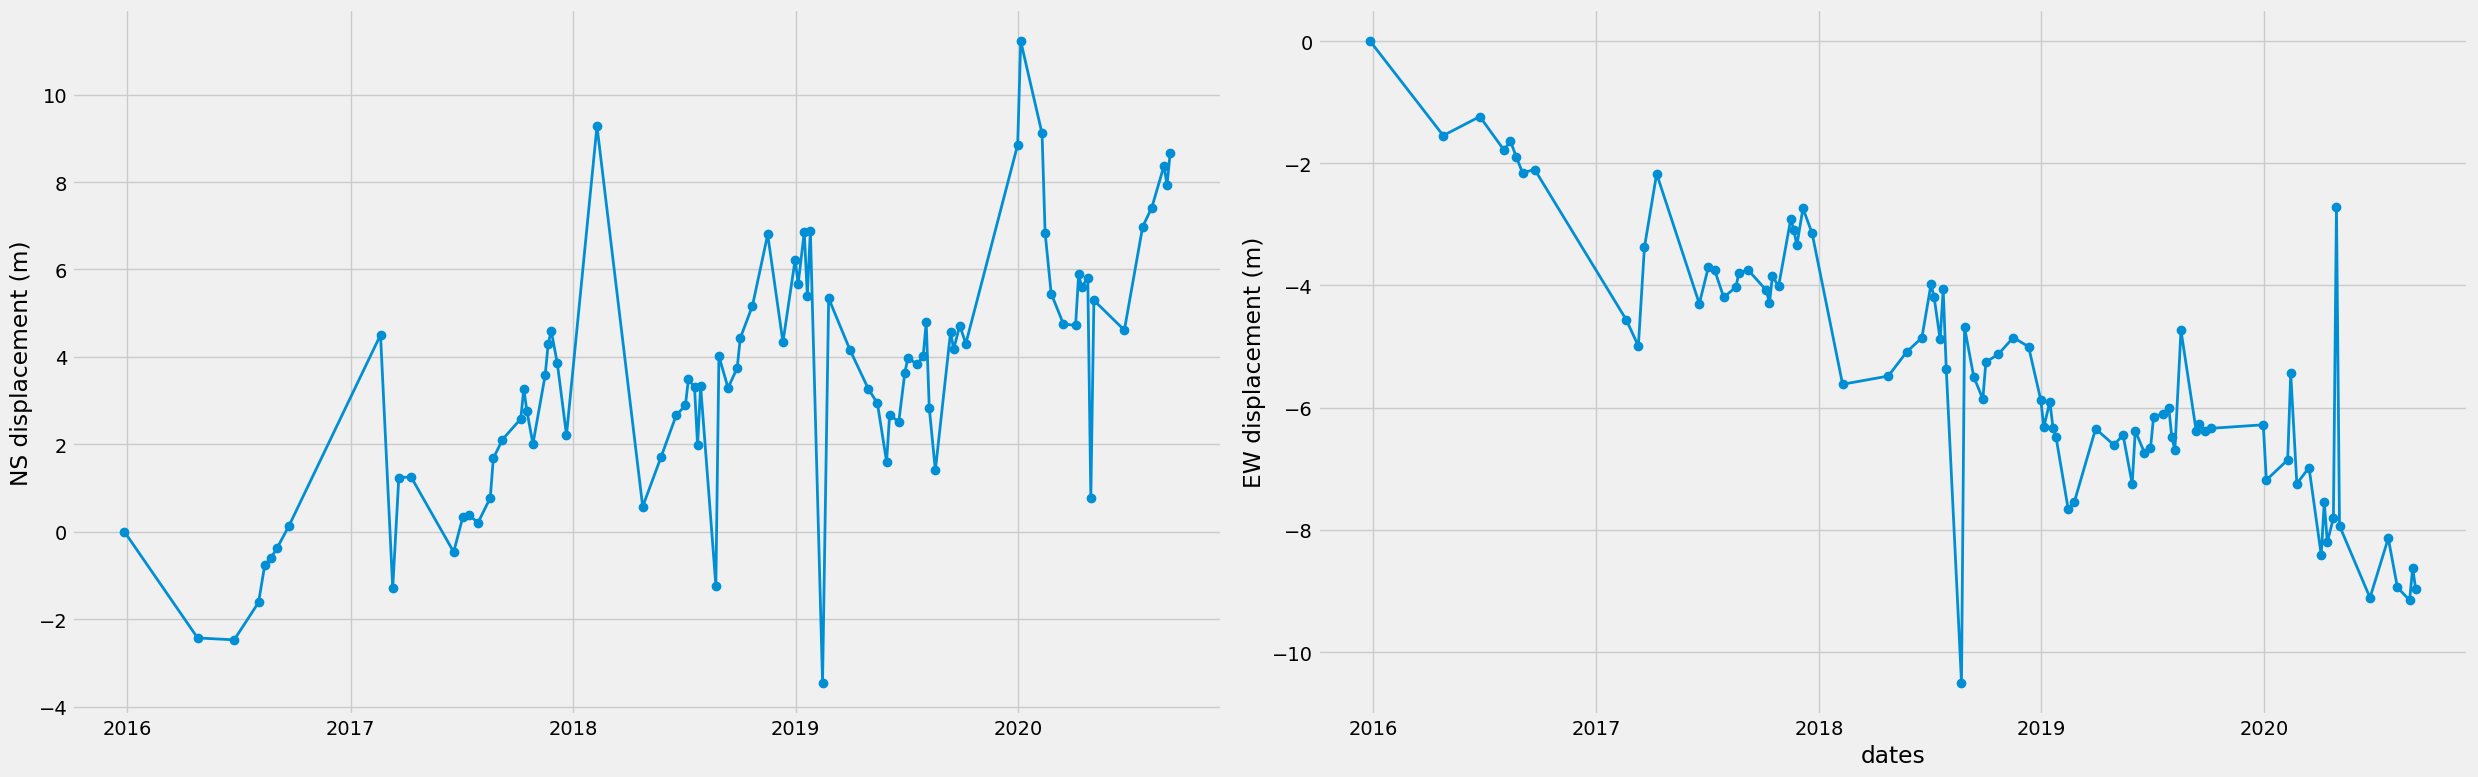

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(25,8))
axs[0].plot(pixels[signals[0]].ns, marker='o', linestyle='-', linewidth=2)
axs[0].set_ylabel('NS displacement (m)')
axs[1].plot(pixels[signals[0]].ew, marker='o', linestyle='-', linewidth=2)
axs[1].set_ylabel('EW displacement (m)')
plt.xlabel('dates')
plt.tight_layout()
plt.savefig('disp_landslide.png')
plt.show()

In [652]:
def plot2(azimuths, pix_azimuths, output, ncols=2, colormap='tab20', figsize=(25,15)):
    n = len(azimuths)
    nrows = int(n / ncols) if n % ncols == 0 else int(math.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    for i in range(n):
        axes[int(i / ncols), i % ncols].plot(azimuths[i], color=colors[i])
        axes[int(i / ncols), i % ncols].axhline(y=pix_azimuths[i], color='black', label='pixel azimuth', linestyle='-', linewidth=1)
        axes[int(i / ncols), i % ncols].set_title('gdal azimuth = ' + str(pix_azimuths[i]) + '°')
    plt.savefig(output + '.png')
    fig.tight_layout()
    plt.show()
    
def plot_test(pixels, output, ncols=2, colormap='tab20', figsize=(25,15)):
    n = len(azimuths)
    nrows = int(n / ncols) if n % ncols == 0 else int(math.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    for i in range(n):
        axes[int(i / ncols), i % ncols].plot(pixels[i].ns, color=colors[i])
    plt.savefig(output + '.png')
    fig.tight_layout()
    plt.show()

In [85]:
n = 100000
# 29000, 29317(bien aligné), 77297(bien aligné), 25459
azimuths = np.array(compute_azimuth_serie(pixels[n]))
azimuth = extract_value_from_raster(file, ref, pixels[n].lat, pixels[n].lon)
plt.plot(np.array(azimuths), label='displacement azimuth', marker='o', linewidth=1)
plt.axhline(y=azimuth, color='r', label='pixel azimuth', linestyle='-', linewidth=1)
plt.ylabel('azimuth (°)')
plt.show()

IndexError: list index out of range

## Filtre Coherence

In [29]:
latitudes = [pixel.lat for pixel in pixels]
longitudes = [pixel.lon for pixel in pixels]

In [68]:
ns_coherence = df_ns['Coer'].values
ew_coherence = df_ew['Coer'].values
ns_coherence_std = np.std(ns_coherence)
ew_coherence_std = np.std(ew_coherence)

In [51]:
quantiles = [0.25, 0.5, 0.75]
for quantile in quantiles:
    ns_qt = np.quantile(ns_coherence, quantile)
    ew_qt = np.quantile(ew_coherence, quantile)
    ns_mask = np.where(ns_coherence > ns_qt, True, False)
    ew_mask = np.where(ew_coherence > ew_qt, True, False)
    mask = np.logical_and(ns_mask, ew_mask)
    viz = Visualization()
    viz.generate_kml_file(mask, latitudes, longitudes, 'yellow', filename='filtre_coherence_quantile=' + str(quantile))

## Filtre cohérence vectorielle

In [475]:
from numpy import linalg as LA
def compute_vector_coherence(pixel):
        diff_ns = np.diff(np.squeeze(pixel.ns.values))
        diff_ew = np.diff(np.squeeze(pixel.ew.values))
        num = self.compute_norm(np.sum(diff_ns), np.sum(diff_ew))
        den = np.sum(LAiff_ns, diff_ew)
        return num / den 

In [488]:
from numpy import linalg as LA

def test(x,y):
    return np.sqrt(x * x + y * y)

def compute_vector_coherence(pixel):
        ns = np.diff(pixel.ns.values.flatten())
        ew = np.diff(pixel.ew.values.flatten())
        num = LA.norm([np.sum(ns), np.sum(ew)])
        den = np.sum([test(x,y) for x, y in zip(ns, ew)])
        return num / den

In [ ]:
cutoffs = [0.4, 0.6, 0.7, 0.8]
vfunc = np.vectorize(compute_vector_coherence)
vector_coherence = vfunc(pixels)
for cutoff in cutoffs:
    mask = np.where(vector_coherence > cutoff, True, False)
    Visualization().generate_kml_file(mask, latitudes, longitudes, 'yellow', filename='filtre_vect_coher_cutoff=' + str(cutoff))

#  Calcul des profils de vitesse

In [116]:
factors = [1.5, 2, 2.5, 3]
latitudes = [pixel.lat for pixel in pixels]
longitudes = [pixel.lon for pixel in pixels]
for factor in factors:
    mask = Data.debug_filter_by(factor=factor)
    viz = Visualization()
    viz.generate_kml_file(mask, latitudes, longitudes, 'yellow', filename='filtre_vitesse_sigma=' + str(factor))

In [34]:
Data.test_filter(factor=2.5)
X = Data.non_filtered_ids

In [35]:
len(Data.non_filtered_ids)

3846

In [37]:
#Data.compute_velocities(min_slope=5, ampl=2, ampl_disp=2)
Data.compute_velocities2()

# Clustering des profils de vitesse 

In [44]:
import simplekml
clustering = Clustering(Data, option=0)
clustering.cluster(min_cluster_size=60, min_samples=100, precomputed=False)
#clustering.visualize()
#clustering.generate_kml_file() 

/home/eost-user/miniconda3/envs/sdsc_stage/lib/python3.9/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


In [43]:
clustering.generate_kml_file2()

In [953]:
from math import sin, cos, sqrt, atan2, radians

# le resultat est en mètre
def compute_distance(lat1, lon1, lat2, lon2, R=6371000):
    
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return  R * c

def compute_distance_matrix(latitudes, longitudes):
    size = len(latitudes)
    distances_matrix = np.zeros(shape=(size, size))
    scaler = StandardScaler()
    for n in range(size):
        for m in range(n , size):
            distances_matrix[n, m] = compute_distance(latitudes[n], longitudes[n], latitudes[m], longitudes[m])
            distances_matrix[m, m] = distances_matrix[n, m]
    return distances_matrix

In [1001]:
from math import radians
clustering = pd.read_csv('clustering_result.csv')
# conversion des degrées en radian 
X = clustering[['Lat', 'Lon']].applymap(radians)

In [891]:
from sklearn.cluster import DBSCAN

In [1004]:
clustering_ = DBSCAN(eps=10, min_samples=5,  metric='haversine').fit(X)
labels = clustering_.labels_

In [ ]:
colors = [plt.cm.Spectral(n)
          for n in np.linspace(0, 1, len(labels))]

for label, color in zip(labels, colors):
    class_mask = (labels == label)
    xx = latitudes[class_mask]
    yy = longitudes[class_mask]
    plt.plot(xx , yy, 'o', markerfacecolor=tuple(color), markeredgecolor='k', markersize=6)
plt.show()

# Analyse visuelle des clusters

In [510]:
def compute_adfuller(serie):
    adf_result = adfuller(serie)
    adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
        adf_output['Critical Value (%s)'%(key)] = value
    return adf_output[1]

In [ ]:
#n= 390
viz = Visualization()
index = Data.non_filtered_ids
#viz.plot_disp_ns_ew(Data.pixels[n].ns , Data.pixels[n].ew)
viz.plot_disp_vel(Data.pixels[n].ns, Data.pixels[n].ew, Data.velocities[Data.non_filtered_ids.index(n)])

# Analyse en composantes principales

# Clustering des champs de vitesses

In [13]:
import rasterio
from pyproj import Proj

In [14]:
velocities_path = 'rasters/mpic/'
mean_velocity_ns_filename = 'MM_Mean_velocity_NS_31TGK_20151227_to_20200906.tif'
mean_velocity_ew_filename = 'MM_Mean_velocity_EW_31TGK_20151227_to_20200906.tif'
analysis_quality_map_filename = 'MM_Analysis_quality_map_1126_lay_31TGK_20151227_to_20200906.tif'
vector_coherence_filename = 'MM_Vector_coherence_31TGK_20151227_to_20200906.tif'
mean_velocity_magnitude_filename = 'MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif'

In [15]:
ns_velocities_rasterio = rasterio.open(velocities_path + mean_velocity_ns_filename)
ns_velocities_raster = gdal.Open(velocities_path + mean_velocity_ns_filename)
ew_velocities_raster = gdal.Open(velocities_path + mean_velocity_ew_filename)
analysis_quality_raster = gdal.Open(velocities_path + analysis_quality_map_filename)
vector_coherence_raster = gdal.Open(velocities_path + vector_coherence_filename)
velocity_magnitude_raster = gdal.Open(velocities_path + mean_velocity_magnitude_filename)

In [16]:
ns_velocities = ns_velocities_raster.GetRasterBand(1).ReadAsArray()
ew_velocities = ew_velocities_raster.GetRasterBand(1).ReadAsArray()
analysis_quality = analysis_quality_raster.GetRasterBand(1).ReadAsArray()
vector_coherence = vector_coherence_raster.GetRasterBand(1).ReadAsArray()
velocity_magnitude_g = velocity_magnitude_raster.GetRasterBand(1).ReadAsArray()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize =(10, 5), tight_layout = True)
axs[0].hist(velocity_magnitude.flatten(), color='g', label='velocity magnitude')
axs[0].legend(loc='best')
axs[1].hist(vector_coherence.flatten(), color='r', label='vector coherence')
axs[1].legend(loc='best')
plt.show()

In [17]:
def convert_to_lat_lon(x, y, epsg_code='32631'):
    proj = Proj("epsg:" + epsg_code, preserve_units=False)
    return p(x, y, inverse=True)


def compute_lat_lon_matrix(raster):
    latitudes, longitudes = [], []
    for i in range(raster.height):
        for j in range(raster.width):
            utms = raster.transform * (i, j)
            lat, lon = convert_to_lat_lon(utms[0], utms[1])
            latitudes.append(lat)
            longitudes.append(lon)
    return np.array(latitudes).reshape(raster.height, raster.width), np.array(longitudes).reshape(raster.height, raster.width)

def generate_kml_file(latitudes, longitudes, color, zone, filename):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for latitude, longitude in zip(latitudes, longitudes):
        pnt = kml.newpoint(description='', coords=[(latitude, longitude)])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save('Resultats/zone' + str(zone) + '/' + filename + '.kml')
    
    
def generate_kml_file2(latitudes, longitudes, color, filename):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for latitude, longitude in zip(latitudes, longitudes):
        pnt = kml.newpoint(description='', coords=[(latitude, longitude)])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save('Resultats/' + filename + '.kml')
   

In [ ]:
chunk_size = 50000
chunk_num = 0

chunks = pd.read_csv('new_zone_lat_lon.csv', chunksize=chunk_size)
for chunk in chunks:
    chunk.to_csv('geo_chunk_' + str(chunk_num) + '.csv', index=False)
    print(chunk_num)
    chunk_num += 1

In [18]:
inpath = 'rasters/mpic/'
input_filenames = [mean_velocity_ns_filename, mean_velocity_ew_filename, mean_velocity_magnitude_filename, vector_coherence_filename]
output_filenames  = ['velocity_NS', 'velocity_EW', 'veloc_magnitude', 'Vector_coherence']

In [19]:
class Raster():
    
    def __init__(self):
        pass
    
    def split_raster2(self, in_path, input_filename, output_filename, x_pixel_step, y_pixel_step):

        ds = gdal.Open(in_path + input_filename)
        xsize = ds.RasterXSize
        ysize = ds.RasterYSize
        
        n_count = 0
        for i in range(0, xsize, x_pixel_step):
            for j in range(0, ysize, y_pixel_step):
                print(i,j, n_count)
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(x_pixel_step) + ", " + str(y_pixel_step) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1
    
    def split_raster(self, in_path, input_filename, output_filename, n_split=5):

        ds = gdal.Open(in_path + input_filename)
        band = ds.GetRasterBand(1)
        xsize = band.XSize
        ysize = band.YSize

        tile_size_x = math.ceil(xsize / n_split)
        tile_size_y = ysize # on découpe le raster verticalement !
        n_count = 0
        for i in range(0, xsize, tile_size_x):
            for j in range(0, ysize, tile_size_y):
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1
        ds = None
        
    def split_rasters2(self, in_path, input_filenames, output_filenames,  x_pixel_step=3323, y_pixel_step=371):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster2(in_path, input_filename, output_filename, x_pixel_step=x_pixel_step, y_pixel_step=y_pixel_step)

    def split_rasters(self, in_path, input_filenames, output_filenames, n_split=5):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster(in_path, input_filename, output_filename, n_split=n_split)
        
    def load_split_rasters(self, in_path, output_filenames, n_splits=5):
        rasters, filenames_to_load = [], []
        for output_filename in output_filenames:
            filenames_to_load.append(['split_' + output_filename + '_' + str(n) + '.tif' for n in range(n_splits)])
        for n in range(n_splits):
            files = [rasterio.open(in_path + files[n]) for files in filenames_to_load]
            rasters.append(tuple(files))
        return rasters
    
    def getBoxBounds(self, raster):
        min_y = raster.bounds.bottom
        max_y = raster.bounds.top
        min_x = raster.bounds.left
        max_x = raster.bounds.right
        min_lat, min_lon = proj(min_x, min_y, inverse=True)
        max_lat, max_lon = proj(max_x, max_y, inverse=True)
        return (min_x, min_y, max_x, max_y), (min_lon, min_lat, max_lon, max_lat)
    
    def compute_slope_azimuth_map(self, dem_path, output_name):
        dem = gdal.Open(dem_path)
        slope_map = gdal.DEMProcessing('rasters/azimuths/' + output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)
    
    def compute_slope_azimuth_map_from_scratch():
        pass
    
    def extract_value_from_raster(self, lat, lon, file, ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return float(val)
    
    def generate_shapefile(self, raster_in_path, shapefile_out_path):
        cmd = ["gdaltindex", shapefile_out_path, raster_in_path]
        subprocess.run(cmd1)
        
    def get_raster_resolution(self, raster):
        xres, yres = rasterio.open(raster).res
        return xres, yres
    
    def cut_raster(raster_output, shapefile_output, xres, yres):
        small_raster = gdal.Warp(raster_output, ds, cutlineDSName=shapefile_output, cropToCutline=True, dstNodata=np.nan, xRes=pxsz, yRes=pysz, resampleAlg='cubic')
        small_raster = None
    
    def split_raster3(self, in_path, input_filename, output_filename, x_pixel_step, y_pixel_step):
        raster = gdal.Open(in_path + input_filename)
        gt = raster.GetGeoTransform()
        
        xmin = gt[0]
        ymax = gt[3]
        res = gt[1]
        xlen = res * raster.RasterXSize
        ylen = res * raster.RasterYSize

        xsize = x_pixel_step * res
        ysize = y_pixel_step * res

        xnsplits = int(raster.RasterXSize / x_pixel_step)
        ynsplits = int(raster.RasterYSize / y_pixel_step)

        xsteps = [xmin + xsize * i for i in range(xnsplits + 1)]
        ysteps = [ymax - ysize * i for i in range(ynsplits + 1)]
    
        n_count = 0
        for i in range(xnsplits):
            for j in range(ynsplits):
                xmin_ = xsteps[i]
                xmax_ = xsteps[i + 1]
                ymax_ = ysteps[j]
                ymin_ = ysteps[j + 1]
                print(xmin_, xmax_, ymin_, ymax_)
                #gdal.Warp(raster_filename + str(i) + str(j) + '.tif', raster, outputBounds=(xmin_, xmax_, ymin_, ymax_), dstNodata=-9999)
                gdal.Translate(inpath + 'split_' + output_filename + '_' + str(n_count) + '.tif', raster, projWin=(xmin_, ymax_, xmax_, ymin_))
                n_count += 1
        raster = None
        
                
    def split_rasters3(self, in_path, input_filenames, output_filenames,  x_pixel_step=3323, y_pixel_step=371):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster3(in_path, input_filename, output_filename, x_pixel_step, y_pixel_step)
            
            
    def from_utm_to_lat_lon(self, filename):
        # Read raster
        with rasterio.open(filename) as r:
            T0 = r.transform  # upper-left pixel corner affine transform
            p1 = Proj(r.crs)
            A = r.read()  # pixel values

        # All rows and columns
        cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

        # Get affine transform for pixel centres
        T1 = T0 * Affine.translation(0.5, 0.5)
        # Function to convert pixel row/column index (from 0) to easting/northing at centre
        rc2en = lambda r, c: (c, r) * T1

        # All eastings and northings (there is probably a faster way to do this)
        eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

        # Project all longitudes, latitudes
        p2 = Proj(proj='latlong',datum='WGS84')
        lats, lons = transform(p1, p2, eastings, northings)

        return lats, lons

In [20]:
def split_raster(in_path, input_filename, output_filename, xpixels=3323, ypixels=371):

        ds = gdal.Open(in_path + input_filename)
        xsize = ds.RasterXSize
        ysize = ds.RasterYSize
        
        n_count = 0
        for i in range(0, xsize, xpixels):
            for j in range(0, ysize, ypixels):
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(xpixels) + ", " + str(ypixels) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1

In [24]:
split_raster('rasters/mpic/','MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif', 'rasters/test')

In [ ]:
Raster().split_rasters3(inpath, input_filenames, output_filenames)

In [25]:
rasters = Raster().load_split_rasters(inpath, output_filenames)

In [26]:
sigma_mean_vel = np.nanstd(velocity_magnitude_g)

In [36]:
rasterio.open('rasters/mpic/MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif').read(1).shape

(1855, 3323)

In [13]:
raster = rasterio.open('rasters/mpic/splt_veloc_half.tif')
lats, lons = Raster().from_utm_to_lat_lon(raster.name)
lats = lats.flatten()
lons = lons.flatten()
n = 4
sigma = np.nanstd(raster.read(1))
mask =  raster.read(1).flatten() > 2 * sigma
mask_index = np.where(mask)
generate_kml_file(lats[mask], lons[mask], 'yellow', n + 1,  filename='first_val_zone_test')

NameError: name 'Affine' is not defined

In [84]:
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
# 1, 1.5, 2, 2.5, 3
factors = np.array([0.0])
# 0.2, 0.4, 0.5, 0.6, 0.7
coherences = np.array([0.0])
# extract rasters 40, 30, 35

for n in [1, 2, 3]:
    mean_ns_velocity_r, mean_ew_velocity_r, velocity_magnitude_r, coherence_r = rasters[n]
    # extract rasters as array and reshape them
    mean_ns_velocity = mean_ns_velocity_r.read(1)
    # East-West velocities
    mean_ew_velocity = mean_ew_velocity_r.read(1)
    # velocity magnitude
    velocity_magnitude = velocity_magnitude_r.read(1)
    # coherence
    coherence = coherence_r.read(1)
    # latitudes, longitudes
    print(velocity_magnitude_r.name)
    lats, lons = Raster().from_utm_to_lat_lon(velocity_magnitude_r.name)
    lats = lats.flatten()
    lons = lons.flatten()

    mask = (velocity_magnitude.flatten() > 1.5 * sigma_mean_vel) 
    
    #latitudes.append(lats[i, j])
    # longitudes.append(lons[i, j])
    print('i')
    generate_kml_file(lats[mask], lons[mask], 'yellow', n + 1,  filename='zone='+ str(n+1) + '_' + 'factor=' + str(factor) + '_coherence=' + str(cor))
    print('l')

rasters/mpic/split_veloc_magnitude_1.tif


<ipython-input-61-1599358040c4>:136: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-61-1599358040c4>:143: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


i


KeyboardInterrupt: 

In [21]:
import subprocess

def cut_raster(root_input, root_output, input_filenames, output_filenames, zone,  x_offset, y_offset, x_npixels, y_npixels):
    n_count = 0
    for input_filename, output_filename in zip(input_filenames, output_filenames):
        cmd = [
            "gdal_translate",
            "-srcwin", str(x_offset), str(y_offset), str(x_npixels), str(y_npixels),
            root_input + input_filename, root_output + 'zone' + str(zone) + '/' +  output_filename + '.tif']
        n_count += 1
        subprocess.run(cmd)
        
def load_cut_raster(root_output, zone, output_filenames):
    data = []
    filenames = [root_output + 'zone' + str(zone) + '/' +  output_filename + '.tif' for output_filename in output_filenames]
    print(filenames)
    return [rasterio.open(filename) for filename in filenames]
        

In [22]:
root_input = 'rasters/mpic/'
root_output = 'rasters/mpic/zones/'
input_filenames = [mean_velocity_ns_filename, mean_velocity_ew_filename, mean_velocity_magnitude_filename, vector_coherence_filename]
output_filenames  = ['velocity_NS', 'velocity_EW', 'veloc_magnitude', 'Vector_coherence']

In [160]:
cut_raster(root_input, root_output,  input_filenames, output_filenames, 1, 1200, 350, 500, 600)

In [25]:
cut_raster(root_input, root_output,  input_filenames, output_filenames, 2, 2200, 700, 200, 200)

In [26]:
cut_raster(root_input, root_output,  input_filenames, output_filenames, 3, 2450, 800, 200, 200)

In [27]:
cut_raster(root_input, root_output,  input_filenames, output_filenames, 4, 2050, 500, 150, 100)

In [29]:
def compute_filtering(rasters, zone, color, n_splits=4, factors = [0, 2, 2.5, 3, 3.5, 4], coherences = [0, 0.1, 0.2, 0.3, 0.5, 0.6]):
    
    ns_velocity_r, ew_velocity, veloc_magnitude_r, vector_coherence_r = tuple(rasters)
    lats, lons = Raster().from_utm_to_lat_lon(veloc_magnitude_r.name)
    lats = lats.flatten()
    lons = lons.flatten()
    lats_split = np.split(lats, n_splits)
    lons_split = np.split(lons, n_splits)
    sigma = np.nanstd(veloc_magnitude_r.read(1))
    #mask_coherences = [coherence.read(1) > cor for cor in coherences]
    #mask_velocities = [veloc_magnitude_r.read(1) > factor * sigma for factor in factors]
    for factor in factors:
        for cor in coherences:
            arguments = []
            mask = (veloc_magnitude_r.read(1) > factor * sigma)
            mask = mask.flatten()
            mask_split = np.split(mask, n_splits)
            for n in range(n_splits):
                filename = 'factor=' + str(factor) + '_' + 'coherence=' + str(cor) + '_' + 'zone_split_' + str(n)
                arguments.append((lats_split[n][mask_split[n]], lons_split[n][mask_split[n]], color, filename))
            with Pool(4) as pool:
                results = pool.starmap(generate_kml_file2, arguments)

In [101]:
def compute_azimuths(rvl_azimuths, rvl_ns_vel, rvl_ew_vel, tol=50):
    Raster().compute_slope_azimuth_map('rasters/mnt/validation_zone_1.tif','validation_zone_1')
    gdal_azimuths = rasterio.open(rvl_azimuths).read(1)
    ns_velocities = rasterio.open(rvl_ns_vel).read(1)
    ew_velocities = rasterio.open(rvl_ew_vel).read(1)
    azimuths = np.arctan2(ew_velocities, ns_velocities)
    azimuths = np.where(azimuths >= 0, azimuths, azimuths + 2 * np.pi)
    azimuths = np.degrees(azimuths)
    #azimuths_mask = np.logical_and(azimuths > gdal_azimuths - tol, azimuths < gdal_azimuths + tol)
    return gdal_azimuths, azimuths

In [95]:
rvl_azimuths = 'rasters/azimuths/validation_zone_1.tif'
rvl_ns_vel = 'rasters/mpic/zones/zone1/velocity_NS.tif'
rvl_ew_vel = 'rasters/mpic/zones/zone1/velocity_EW.tif'
gdal_azimuths, azimuths= compute_azimuths(rvl_azimuths, rvl_ns_vel, rvl_ew_vel)


In [31]:
from multiprocessing import Pool
n_splits = 4
color = 'yellow'
factors = [0, 2.5, 3, 3.5, 4]
coherences = [0, 0.1, 0.2, 0.3, 0.5, 0.6]
fname = 'rasters/mpic/validation_zone1.tif'
#fname = 'rasters/mpic/zones/zone1/Vector_coherence.tif'
raster = rasterio.open(fname)
lats, lons = Raster().from_utm_to_lat_lon(fname)
lats = lats.flatten()
lons = lons.flatten()
std_vel = np.nanstd(raster.read(1))
mask = raster.read(1) > 1.5 * std_vel
mask = mask.flatten()
arguments = []
lats_split = np.split(lats, n_splits)
lons_split = np.split(lons, n_splits)
mask_split = np.split(mask, n_splits)
for n in range(n_splits):
    arguments.append((lats_split[n][mask_split[n]], lons_split[n][mask_split[n]], color, 'zone_split_' + str(n)))
with Pool(4) as pool:
    results = pool.starmap(generate_kml_file2, arguments)

<ipython-input-21-c7ee34eb6657>:139: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-21-c7ee34eb6657>:146: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


In [34]:
def generate_kml_file_ll(latitudes, longitudes, labels):
    if labels.max() > -1:
        icones = generate_icones2()
        dense_cluster_labels = get_important_labels(labels)
        kml=simplekml.Kml()
        fol = kml.newfolder(name="HDBSCAN Clustering")
        for n in range(latitudes.shape[0]):
            print(n, latitudes.shape, labels.shape)
            if labels[n] > -1 and labels[n] in dense_cluster_labels:
                ind = dense_cluster_labels.index(labels[n])
                pnt = fol.newpoint(description='', coords=[(latitudes[n], longitudes[n])])
                pnt.iconstyle.icon.href = icones[ind]
        kml.save('Resultats/clustering_results.kml')
        print('ok finished')
    else:
        print('Hdbscan only found outliers. kml file cannot be generated !')
            
def generate_icones2():
    base = 'http://maps.google.com/mapfiles/ms/micons/'
    colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
    return [base + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [base + color + '.png' for color in (colors + ['lightblue'])[:]]

def get_important_labels(labels, n_classes=15):
    classes = []
    unique, counts = np.unique(labels, return_counts=True)
    sort_labels = sorted(dict(zip(unique, counts)).items(), key=lambda x: x[1], reverse=True)
    for label, count in sort_labels:
        if label > -1 and len(classes) < n_classes:
            classes.append(label)
    return classes

In [83]:
fname = 'rasters/mpic/zones/zone1/Vector_coherence.tif'
raster = rasterio.open(fname)
mean  = np.nanmean(raster.read(1).flatten())
mask =  raster.read(1).flatten() >  mean

In [126]:
tol = 50
azimuths_mask = np.logical_and(azimuths > gdal_azimuths - tol, azimuths < gdal_azimuths + tol)
azimuths_mask.flatten()

array([ True, False, False, ...,  True,  True,  True])

In [121]:
import hdbscan

min_cluster_size = 30
min_samples = 50

#fname = 'rasters/mpic/validation_zone1.tif'
fname = 'rasters/mpic/validation_zone2.tif'
#fname = 'rasters/mpic/validation_zone3.tif'
#fname = 'rasters/mpic/zones/zone1/Vector_coherence.tif'
raster = rasterio.open(fname)
lats, lons = Raster().from_utm_to_lat_lon(fname)
lats = lats.flatten()
lons = lons.flatten()
std_vel = np.nanstd(raster.read(1))
print(std_vel)
mask = (raster.read(1) > 1.5 * std_vel)
#mask = raster.read(1) > np.nanmean(raster.read(1))
mask = mask.flatten()

lats_r = np.radians(lats[mask])
lons_r = np.radians(lons[mask])
X = np.stack((lats_r, lons_r), axis=-1)

clustering_results = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,  gen_min_span_tree=True, metric='haversine').fit(X)

<ipython-input-65-c7ee34eb6657>:139: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-65-c7ee34eb6657>:146: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


0.0


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [128]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

ew_velocities_zone1 = rasterio.open('rasters/mpic/zones/zone1/velocity_EW.tif').read(1)
ns_velocities_zone1 = rasterio.open('rasters/mpic/zones/zone1/velocity_NS.tif').read(1)
velocities_zone1 = rasterio.open('rasters/mpic/zones/zone1/veloc_magnitude.tif').read(1)

std_vel = np.nanstd(velocities_zone1)
mask_vel = velocities_zone1.flatten() >  2.5 * std_vel 
mask_nan = np.isnan(velocities_zone1.flatten())

In [ ]:
ew_vel = ew_velocities_zone1.flatten()[mask_vel]
ns_evl = ns_velocities_zone1.flatten()[mask_vel]
vectors = np.stack((ew_vel, ns_evl), axis=-1)
similarity_matrix = cosine_similarity(vectors)
#clustering_results = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=None,  gen_min_span_tree=True, metric='cosine').fit(vectors)

In [17]:
raster = rasterio.open('rasters/veloc_mag_2.tif')
lats, lons = Raster().from_utm_to_lat_lon('rasters/veloc_mag_2.tif')
sig = np.nanstd(raster.read(1))
latitudes, longitudes = [], []
    
mask = raster.read(1) > 0 * sig
mask_index = np.where(mask)
print(factor, cor)
for i, j in zip(mask_index[0], mask_index[1]):
     #x, y = velocity_magnitude_r.xy(i, j)
    #lat, lon = proj(x, y, inverse=True)
    latitudes.append(lats[i, j])
    longitudes.append(lons[i, j])

generate_kml_file(latitudes, longitudes, 'yellow', n + 1,  filename='zone='+ str(n+1) + 'ppp')

<ipython-input-11-1599358040c4>:136: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-11-1599358040c4>:143: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


NameError: name 'factor' is not defined

In [86]:
epsg_code = '32631'
proj = Proj("epsg:" + epsg_code, preserve_units=False)
# 1, 1.5, 2, 2.5, 3
factors = np.array([0.0])
# 0.2, 0.4, 0.5, 0.6, 0.7
coherences = np.array([0.0])
# extract rasters 40, 30, 35

for n in range(5):
    mean_ns_velocity_r, mean_ew_velocity_r, velocity_magnitude_r, coherence_r = rasters[n]
    # extract rasters as array and reshape them
    mean_ns_velocity = mean_ns_velocit.concatenatey_r.read(1)
    # East-West velocities
    mean_ew_velocity = mean_ew_velocity_r.read(1)
    # velocity magnitude
    velocity_magnitude = velocity_magnitude_r.read(1)
    # coherence
    coherence = coherence_r.read(1)
    # latitudes, longitudes
    print(velocity_magnitude_r.name)
    lats, lons = Raster().from_utm_to_lat_lon(velocity_magnitude_r.name)
    
    latitudes, longitudes = [], []
    mask = (velocity_magnitude > 0 * sigma_mean_vel) & (coherence > cor)
    mask_index = np.where(mask)
    for i, j in zip(mask_index[0], mask_index[1]):
                #x, y = velocity_magni.concatenatetude_r.xy(i, j)
                #lat, lon = proj(x, y, inverse=True)
        latitudes.append(lats[i, j])
        longitudes.append(lons[i, j])
    generate_kml_file(latitudes, longitudes, 'yellow', n + 1,  filename='zone='+ str(n+1) + '_' + 'factor=' + str(factor) + '_coherence=' + str(cor))

rasters/mpic/split_veloc_magnitude_0.tif


<ipython-input-61-1599358040c4>:136: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-61-1599358040c4>:143: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


rasters/mpic/split_veloc_magnitude_1.tif


<ipython-input-61-1599358040c4>:136: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-61-1599358040c4>:143: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


rasters/mpic/split_veloc_magnitude_2.tif


<ipython-input-61-1599358040c4>:136: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-61-1599358040c4>:143: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


rasters/mpic/split_veloc_magnitude_3.tif


<ipython-input-61-1599358040c4>:136: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-61-1599358040c4>:143: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


KeyboardInterrupt: 

#  Clustering avec la similarité cosinus